# Overview:

Done:

* Able to get the neuron_output
* Training

To-do:

* for AlexNet, the filter size, stridel, padding size change across different layers --> need to address this?
* pre-trained = True --> is this correct? 
* check if *list method is correct 

References:

https://deeplearning.neuromatch.io/projects/Neuroscience/blurry_vision.html?highlight=alexnet

https://www.kaggle.com/asilvaigor/learning-alexnet

https://www.kaggle.com/drvaibhavkumar/alexnet-in-pytorch-cifar10-clas-83-test-accuracy

https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3?u=klory

https://distill.pub/2017/feature-visualization/

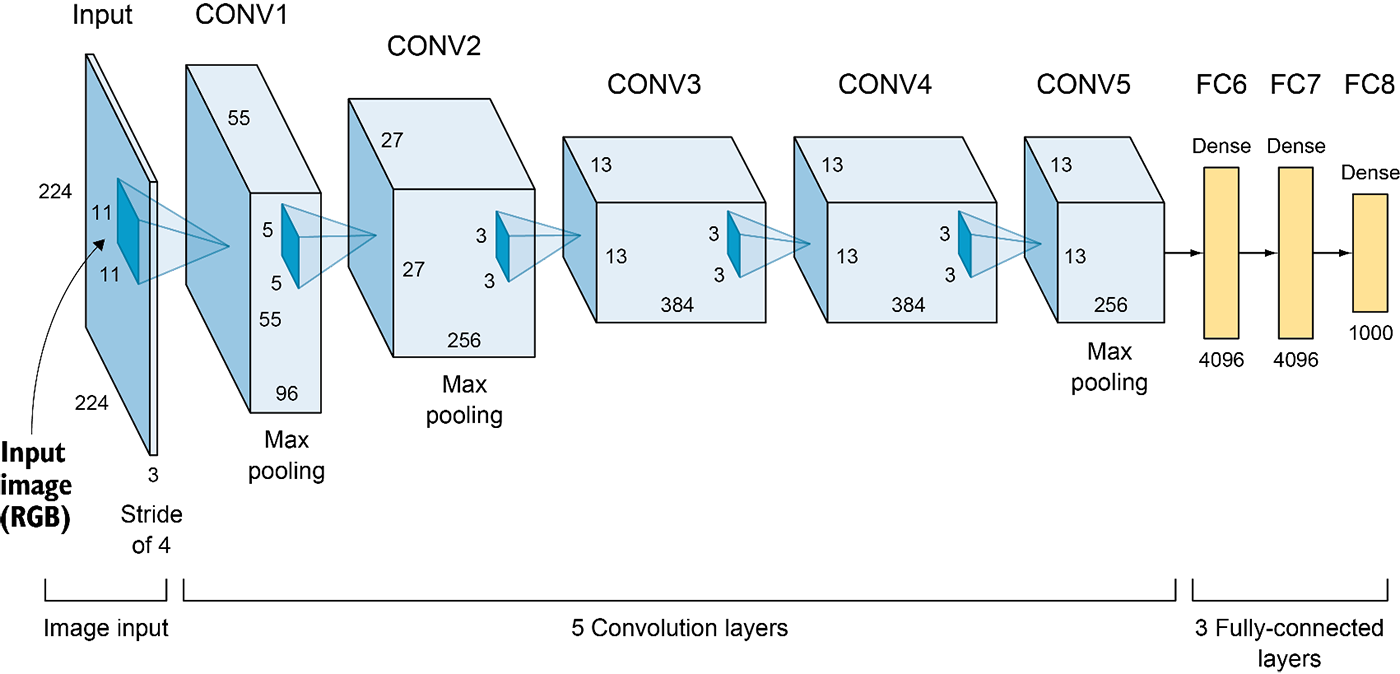

In [1]:
import tensorflow as tf
import numpy as np
import pathlib
import datetime

# printout versions
print(f"Tensor Flow Version: {tf.__version__}")
print(f"numpy Version: {np.version.version}")

Tensor Flow Version: 2.7.0
numpy Version: 1.19.5


In [2]:
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import InputLayer, Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.python.keras import backend as K
import math

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import torch.optim as optim
import time

In [4]:
print(torch.__version__)

1.10.0+cu111


In [5]:
print(torchvision.__version__)

0.11.1+cu111


# Loading CIFAR-10 data:

In [6]:
transform = transforms.Compose([
    transforms.Resize(128),
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)

test_data = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)

classes = ('Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
train_data[1][0]

tensor([[[ 0.5193,  0.5193,  0.4679,  ..., -0.7479, -0.7650, -0.7650],
         [ 0.5193,  0.5193,  0.4679,  ..., -0.7479, -0.7650, -0.7650],
         [ 0.4851,  0.4851,  0.4508,  ..., -0.7650, -0.7822, -0.7822],
         ...,
         [ 0.6734,  0.6734,  0.6563,  ...,  0.2967,  0.3138,  0.3138],
         [ 0.6734,  0.6734,  0.6563,  ...,  0.3309,  0.3309,  0.3309],
         [ 0.6734,  0.6734,  0.6563,  ...,  0.3309,  0.3309,  0.3309]],

        [[ 1.0630,  1.0630,  0.9755,  ..., -0.6001, -0.6176, -0.6176],
         [ 1.0630,  1.0630,  0.9755,  ..., -0.6001, -0.6176, -0.6176],
         [ 1.0280,  1.0280,  0.9405,  ..., -0.6176, -0.6352, -0.6352],
         ...,
         [ 0.5728,  0.5728,  0.5728,  ...,  0.2577,  0.2752,  0.2752],
         [ 0.5553,  0.5553,  0.5553,  ...,  0.2927,  0.2927,  0.2927],
         [ 0.5553,  0.5553,  0.5553,  ...,  0.2927,  0.2927,  0.2927]],

        [[ 1.4548,  1.4548,  1.3502,  ..., -0.5844, -0.5844, -0.5844],
         [ 1.4548,  1.4548,  1.3502,  ..., -0

In [9]:
N_train = 50000
N_test = 10000
img_shape = (3, 32, 32) #use a tuple in the fomat: (n_channels, height, width)
n_classes = 10
print(N_train,N_test,img_shape,n_classes)

50000 10000 (3, 32, 32) 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


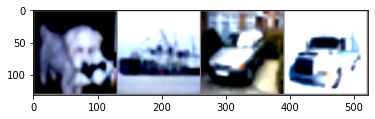

  Dog  Ship   Car Truck


In [10]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
im = images[0]

In [12]:
im.shape

torch.Size([3, 128, 128])

In [13]:
imshift = np.roll(im, shift = 10, axis=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


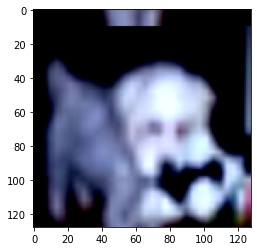

In [14]:
imshow(torch.tensor(imshift))

In [15]:
imshift = np.roll(im, shift = 10, axis=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


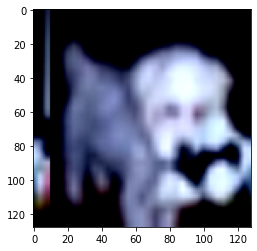

In [16]:
imshow(torch.tensor(imshift))

# Training AlexNet:

In [17]:
# Define AlexNet with different modules representing different brain areas
class AlexNet(nn.Module):

  def __init__(self, num_classes=1000, downscale=1):
    """
    Args:
      num_classes: int
      downscale: int
    """
    super(AlexNet, self).__init__()
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(3, 64//downscale, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(64//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(64//downscale, 192//downscale, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(192//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.conv_layer3 = nn.Sequential(
        nn.Conv2d(192//downscale, 384//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(384//downscale),
    )
    self.conv_layer4 = nn.Sequential(
        nn.Conv2d(384//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
    )
    self.conv_layer5 = nn.Sequential(
        nn.Conv2d(256//downscale, 256//downscale, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256//downscale),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.it = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256//downscale * 6 * 6, 4096//downscale),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096//downscale, 4096//downscale),
        nn.ReLU(inplace=True)
    )
    self.classifier = nn.Linear(4096//downscale, num_classes)

  def forward(self, x):
    """
    Args:
      x: torch.Tensor
    Returns:
      x: torch.Tensor
    """
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.conv_layer3(x)
    x = self.conv_layer4(x)
    x = self.conv_layer5(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.it(x)
    x = self.classifier(x)
    return x

In [18]:
AlexNet_Model = AlexNet(num_classes=10, downscale=2)
AlexNet_Model.eval()

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

In [19]:
# AlexNet_Model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

In [20]:
# import torch.nn as nn
# AlexNet_Model.classifier[1] = nn.Linear(9216,4096)
# AlexNet_Model.classifier[4] = nn.Linear(4096,1024)
# AlexNet_Model.classifier[6] = nn.Linear(1024,10)

In [21]:
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, 11, stride=4),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#             nn.Conv2d(64, 192, 5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#             nn.Conv2d(192, 384, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, 3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x
# from torch.utils import model_zoo
# def alexnet_classifier(num_classes):
#     classifier = nn.Sequential(
#             nn.Dropout(p=0.5, inplace=False),
#             nn.Linear(9216,4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5, inplace=False),
#             nn.Linear(4096,1024),
#             nn.ReLU(inplace=True),
#             nn.Linear(1024,num_classes),
#             nn.Softmax(),
#         )
#     return classifier

# def alexnet(num_classes, pretrained=False, **kwargs):
#     """AlexNet model architecture from the
#     `"One weird trick..." `_ paper.
#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#     """
#     model = AlexNet(**kwargs)
#     if pretrained:
#         model.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth'))
#         for p in model.features.parameters():
#             p.requires_grad=False
#     classifier = alexnet_classifier(num_classes)
#     model.classifier = classifier
#     return model
# model = alexnet(10, True)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet_Model.parameters(), lr=0.001, momentum=0.9)

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
print(device)

cuda:0


In [25]:
AlexNet_Model.to(device)

AlexNet(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer4): Sequential(
    (0): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Ba

# Epoch 1:

In [26]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 1')

[1,  2000] loss: 2.180
Time: 33.63486289978027
[1,  4000] loss: 1.865
Time: 66.90438866615295
[1,  6000] loss: 1.647
Time: 100.12362933158875
[1,  8000] loss: 1.500
Time: 133.38870477676392
[1, 10000] loss: 1.390
Time: 166.64984321594238
[1, 12000] loss: 1.297
Time: 199.91451168060303
Finished Training of AlexNet: Epoch 1


# Get accuracy:

In [27]:
# define function to calculate current accuracy with a given dataloader
def accuracy(dataloader, device='cpu'): #Get the accuracies
  net.eval()
  correct = 0
  count = 0
  for data, target in tqdm.tqdm(dataloader):
    data = data.to(device).float()
    target = target.to(device).long()

    prediction = net(data)
    _, predicted = torch.max(prediction, 1)
    count += target.size(0)
    correct += (predicted == target).sum().item()

  acc = 100 * correct / count
  return count, acc


# define function to evaluate and print training and test accuracy
def evaluate(net, device='cpu', title=""):
  net.eval()
  train_count, train_acc = accuracy(clear_train_batches, device=device)
  test_count, test_acc = accuracy(clear_test_batches, device=device)
  print(f'Accuracy on the {train_count} clear training samples {title}: {train_acc:0.2f}')
  print(f'Accuracy on the {test_count} clear testing samples {title}: {test_acc:0.2f}')
  train_count, train_acc = accuracy(noisy_train_batches, device=device)
  test_count, test_acc = accuracy(noisy_test_batches, device=device)
  print(f'Accuracy on the {train_count} blurry training samples {title}: {train_acc:0.2f}')
  print(f'Accuracy on the {test_count} blurry testing samples {title}: {test_acc:0.2f}')

# Visualizing filters:

In [28]:
def show_weights(layer, i=0):
    filter = layer[0].weight.cpu().data
    filter = (1 / (2 * filter.max())) * filter + 0.5 #Normalizing the values to [0,1]
    print(filter.shape)
    img = torchvision.utils.make_grid(filter)
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 11, 11])
(54, 106, 3)


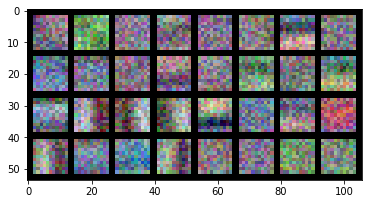

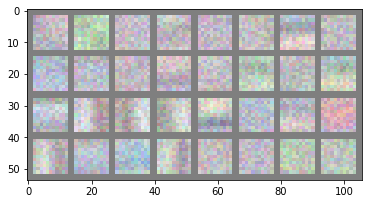

In [29]:
show_weights(AlexNet_Model.conv_layer1)

# Visualizing outputs given an image: 

In [30]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


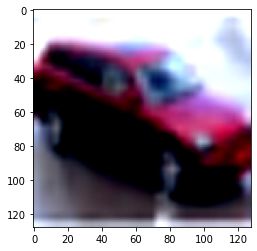

In [31]:
imshow(images[0])

In [32]:
images = images.type(torch.cuda.FloatTensor)
im = images[0].unsqueeze(0)

In [33]:
im.shape

torch.Size([1, 3, 128, 128])

In [34]:
# def plot_intermediate_layers(image, net, return_layers):
#   # Get output for the image from the intermediate layers
#   intermediate_output = LayerGetter(net, return_layers=return_layers)(image)
#   fig = plt.figure(figsize=(12, 3))
#   ax=fig.add_subplot(141)
#   ax.imshow(image.squeeze(0).permute(1, 2, 0))
#   plt.axis('off')
#   plt.title('Original Image')
#   ax=fig.add_subplot(142)
#   ax.imshow(intermediate_output[0]['v1'].detach().cpu().squeeze(0).mean(axis=0))
#   plt.axis('off')
#   plt.title('V1 layer (Average)')
#   ax=fig.add_subplot(143)
#   ax.imshow(intermediate_output[0]['v2'].detach().cpu().squeeze(0).mean(axis=0))
#   plt.axis('off')
#   plt.title('V2 layer (Average)')
#   ax=fig.add_subplot(144)
#   ax.imshow(intermediate_output[0]['v4'].detach().cpu().squeeze(0).mean(axis=0))
#   plt.axis('off')
#   plt.title('V4 layer (Average)')
#   plt.show()

In [35]:
!pip install torch_intermediate_layer_getter

  Created wheel for torch-intermediate-layer-getter: filename=torch_intermediate_layer_getter-0.1.post1-py3-none-any.whl size=3724 sha256=69fff2f0ecf3f2592baec420bd13f7ea14bf0203b70d5cda2d2d8d490c6fc2fb
  Stored in directory: /root/.cache/pip/wheels/59/53/37/8b81c4711686fbae03a35d8d1dac5edd9e4af9221fa8e17f6f
Successfully built torch-intermediate-layer-getter


In [36]:
from torch_intermediate_layer_getter import IntermediateLayerGetter as LayerGetter
return_layers = {
    # "<name of layer in the AlexNet Class>" : "<key for the layer output in the returned dictionary>"
      'conv_layer1': 'conv_layer1',
      'conv_layer3': 'conv_layer3',
      'conv_layer5': 'conv_layer5',
  }
net = AlexNet_Model
LayerGetter = torchvision.models._utils.IntermediateLayerGetter(net, return_layers=return_layers)
intermediate_output = LayerGetter(im)
print(intermediate_output['conv_layer3'].shape)

torch.Size([1, 192, 7, 7])


Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer1')

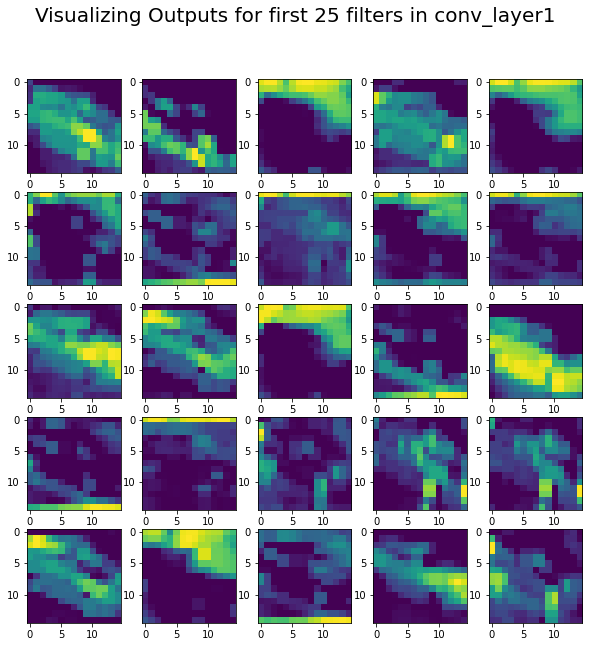

In [37]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer1'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer1', fontsize=20)

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer3')

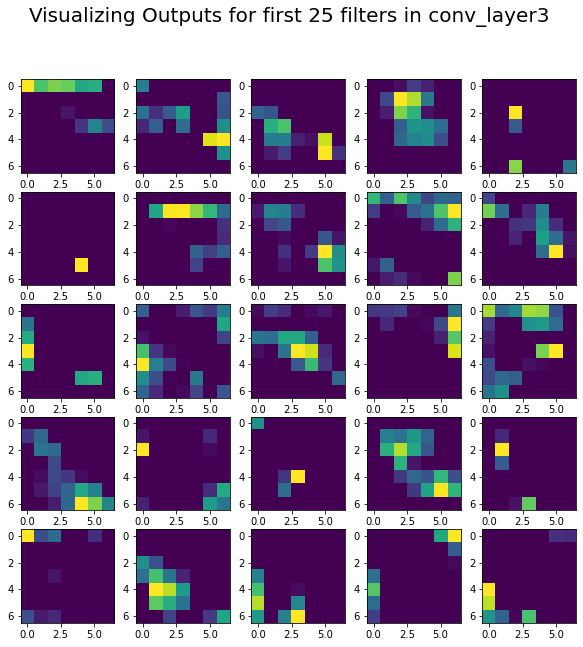

In [38]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer3'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer3', fontsize=20)

Text(0.5, 0.98, 'Visualizing Outputs for first 25 filters in conv_layer5')

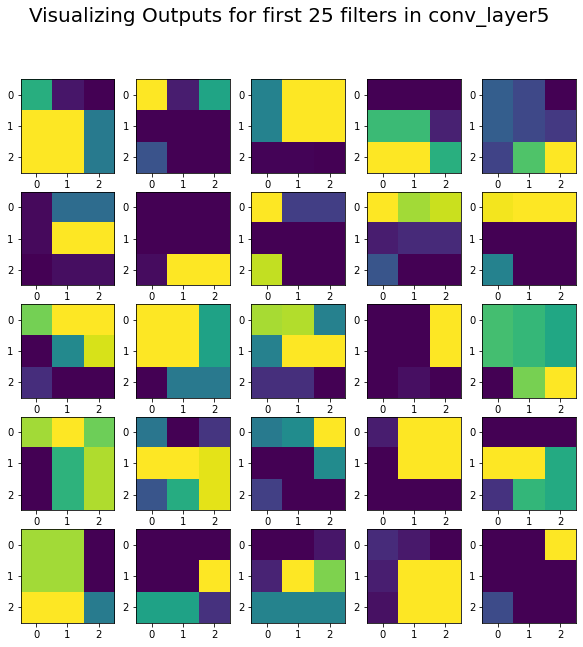

In [39]:
fig, axs = plt.subplots(5, 5, figsize = (10,10))
for i , ax in enumerate(axs.flatten()):    
    ax.imshow(intermediate_output['conv_layer5'][0,i,:,:].cpu().data)
fig.suptitle('Visualizing Outputs for first 25 filters in conv_layer5', fontsize=20)

In [40]:
f = torch.nn.Sequential(*list(AlexNet_Model.children())[:-23])
feature_outputs = f(im)

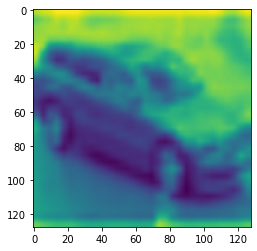

In [41]:
plt.imshow(feature_outputs[0,0,:,:].cpu().data)

In [42]:
f = torch.nn.Sequential(*list(AlexNet_Model.children())[:-15])
feature_outputs = f(im)

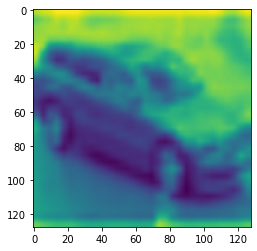

In [43]:
plt.imshow(feature_outputs[0,0,:,:].cpu().data)

# Visualizing embeddings:

In [44]:
AlexNet_Model.children()

<generator object Module.children at 0x7fc395f2fed0>

In [45]:
def apply_all_shifts(im, shift_step):
    '''
    arg(s): 
        DEBUG NOTE: PYTORCH IS (#channels, rows, cols)!!
        im, an image of shape (3, im_size, im_size)
    return: 
        im_all_shifts, a list of all shifted images from the input image
        n_shifts, number of shifted images
    '''
    
    ## vertical size might not be the same as the horizontal
    im_size_vertical = im.shape[1]
    im_size_horizontal = im.shape[2]
    
    n_shifts_vertical = int(math.ceil(im_size_vertical/ shift_step))
    n_shifts_horizontal = int(math.ceil(im_size_horizontal/ shift_step))
    
    im_all_shifts = []
    im_shift = im
    for i in range(n_shifts_vertical):
        im_shift = np.roll(im_shift, shift = shift_step * i, axis=1)
        
        for j in range(n_shifts_horizontal):
            im_shift = np.roll(im_shift, shift = shift_step * j, axis=2)
            im_all_shifts.append(im_shift)
            
    im_all_shifts =  np.array(im_all_shifts)
    return im_all_shifts, n_shifts_vertical * n_shifts_horizontal

In [46]:
def compute_neuron_output_alt(layer_names, images, plot_activity = False):

    '''
    arg(s):
        layer_names: list of strings indicating the names of the layers we want to take neuron outputs from
        images: a tensor of images (stimuli)
    return:
        
    '''
    n_images = images.shape[0]
    n_layers = len(layer_names)
    neuron_output_highest = []
    all_fm_avg = []
    neuron_labels = []
    images = images.type(torch.cuda.FloatTensor)
    
    layer_index = 1
    for layer_name in layer_names:
        ## note: always take the images as inputs
        return_layers = {layer_name: layer_name}
        LayerGetter = torchvision.models._utils.IntermediateLayerGetter(AlexNet_Model, return_layers=return_layers)
        neuron_output = []
        for i in range(n_images):
          im = images[i]
          im = torch.reshape(im, (1, im.shape[0],im.shape[1],im.shape[2]))
          output = LayerGetter(im)
          output = output[layer_name] 
          neuron_output.append(output)
        neuron_output =  torch.stack(neuron_output)
        neuron_output = neuron_output.reshape((neuron_output.shape[0], neuron_output.shape[2], neuron_output.shape[3], neuron_output.shape[4]))

        neuron_output = neuron_output.permute(0, 2, 3, 1)
        
        ## number of neurons is nrow * ncol * n_feature_maps
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        
        ## remove the neurons at the edges
        neuron_output = neuron_output[:,2:(n_row-2),2:(n_col-2),:]
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        neuron_output = neuron_output.reshape((n_images, n_row * n_col, n_feature_maps))
        n_neurons = n_row * n_col
        
        # neuron_index = np.empty((n_row,n_col),dtype=int)
        # index = 0
        # for i in range(n_row):
        #     for j in range(n_col):
        #         neuron_index[i, j] = index
        #         index += 1
                
        # ## obtain the index of the neurons at the edges
        # neuron_edge_index = np.hstack((neuron_index[[0,1,n_row-2,n_row-1],:].reshape((4*32,1)), neuron_index[:,[0,1,n_col-2,n_col-1]].reshape((4*32,1))))
        # neuron_edge_index = neuron_edge_index.reshape((256,1))
        

        # ## re-label the neurons at the edge with a different color
        # neuron_labels = []
        # for i in range(10):    
        #     neuron_labels = np.hstack((neuron_labels, [i] * n_neurons))
        #     neuron_labels = np.array(neuron_labels)
        #     neuron_labels[n_neurons * i + neuron_edge_index-1] = 15
        
        # neuron_output = neuron_output.reshape((n_images, n_neurons, n_feature_maps))
        
        ## transpose to organize by feature maps
        ## neuron_output_by_fm is (n_images, n_feature_maps, #neurons)
        neuron_output_by_fm = neuron_output.permute(0, 2, 1)
        
        ## compute avg neuron firing rate in each feature map
        ## fm_avg is (n_images, n_feature_maps)
        fm_avg = neuron_output_by_fm.sum(axis=2) / neuron_output_by_fm.shape[2]
        
        if layer_index == 1: 
            fm_avg_all_layers = fm_avg
            neuron_output_by_fm_all_layers = neuron_output_by_fm
        else:
            fm_avg_all_layers = np.hstack((fm_avg_all_layers, fm_avg))
            neuron_output_by_fm_all_layers = np.concatenate((neuron_output_by_fm_all_layers,neuron_output_by_fm), axis = 1)

    neuron_output_highest = np.empty((n_images,n_neurons *10))
    fm_avg_all_layers = fm_avg_all_layers.cpu().data
    neuron_output_by_fm_all_layers = neuron_output_by_fm_all_layers.cpu().data
    
    for i in range(n_images):
        max10_indices = np.argpartition(fm_avg_all_layers[i], -10, axis = 0)[-10:]
        neuron_output_highest[i] = neuron_output_by_fm_all_layers[i, max10_indices, :].reshape((1,n_neurons *10))

    for i in range(10):    
        neuron_labels += [i] * n_neurons

    neuron_labels = np.array(neuron_labels)  


    return neuron_output_highest, fm_avg_all_layers, neuron_labels 

In [47]:
def show_stimuli(layer_names, images_selected_classes, shifts, plot_activity = False):
    '''
    arg(s): 
        layer_indices, interested layers
        images_selected_classes, all the selected images
        shifts = True/False
    return:
        neuron_output_shifts_avg, (n_images, n_neurons)
    '''
    
    # images_selected_classes = np.array(images_selected_classes)
    n_images_selected_classes = 40

    if shifts is False:
        neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_names, images_selected_classes, plot_activity = plot_activity)
  
    else: 
        # generate shifts for each selected image: 
        neuron_output_highest_with_shifts = []
        fm_avg_all_layers_with_shifts = []
        for i in range(n_images_selected_classes):
            im = images_selected_classes[i]
            ## DEBUG NOTE: since the images need to be resized to 224x224, shift_step should be larger to prevent crashes
            im_all_shifts, n_shifts =  apply_all_shifts(im, 10)

            im_all_shifts = torch.Tensor(im_all_shifts)

            ## neuron_output_highest is of shape (number of shifts, neurons)
            neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_names, im_all_shifts, plot_activity = False)
             
            if shifts is False:
              neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_names, images_selected_classes, plot_activity = False)
    
            else:
              # generate shifts for each selected image: 
              neuron_output_highest_with_shifts = []
              fm_avg_all_layers_with_shifts = []
              for i in range(n_images_selected_classes):
                  im = images_selected_classes[i]
                  im_all_shifts, n_shifts =  apply_all_shifts(im, 4)
                  im_all_shifts = torch.Tensor(im_all_shifts)

                  ## neuron_output_highest is of shape (number of shifts, neurons)
                  neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_names, im_all_shifts, plot_activity = False)
                  
                  ## take the average over all shifts of im
                  shifts_avg = neuron_output_highest.sum(axis=0) / neuron_output_highest.shape[0]
                  shifts_avg = shifts_avg.reshape((1,shifts_avg.shape[0]))
                  
                  fm_shifts_avg = fm_avg_all_layers.sum(axis=0) / fm_avg_all_layers.shape[0]
                  fm_shifts_avg = fm_shifts_avg.reshape((1,fm_shifts_avg.shape[0]))
                  
                  if i == 0:
                      neuron_output_highest_with_shifts = shifts_avg 
                      fm_avg_all_layers_with_shifts = fm_shifts_avg
                  else:
                      neuron_output_highest_with_shifts = np.vstack((neuron_output_highest_with_shifts, shifts_avg))
                      fm_avg_all_layers_with_shifts = np.vstack((fm_avg_all_layers_with_shifts, fm_shifts_avg))
                      
              neuron_output_highest = neuron_output_highest_with_shifts
              fm_avg_all_layers = fm_avg_all_layers_with_shifts
 
    return neuron_output_highest, fm_avg_all_layers, neuron_labels

Take 40 images, 10 images each in the airplane, automobile, cat, dog classes:

In [48]:
airplane_indices, automobile_indices, cat_indices, dog_indices = [], [], [], []
airplane_idx, automobile_idx, cat_idx, dog_idx = train_data.class_to_idx['airplane'], train_data.class_to_idx['automobile'], train_data.class_to_idx['cat'], train_data.class_to_idx['dog']

i = 0
while(len(airplane_indices) < 10 or len(automobile_indices) < 10 or len(cat_indices) < 10 or len(dog_indices) < 10):
  current_class = train_data[i][1]
  if current_class == airplane_idx:
    airplane_indices.append(i)
  elif current_class == automobile_idx:
    automobile_indices.append(i)
  elif current_class == cat_idx:
    cat_indices.append(i)
  elif current_class == dog_idx:
    dog_indices.append(i)
  i += 1

airplane_indices = airplane_indices[0:10]
automobile_indices = automobile_indices[0:10]
cat_indices = cat_indices[0:10]
dog_indices = dog_indices[0:10]
selected_train_data = Subset(train_data, airplane_indices + automobile_indices + cat_indices + dog_indices)
n_images = 40

In [49]:
# get some random training images
trainloader_images_selected_classes = torch.utils.data.DataLoader(selected_train_data, batch_size=n_images, shuffle=True, num_workers=2)
dataiter_images_selected_classes = iter(trainloader_images_selected_classes)
images_selected_classes, labels_selected_classes = dataiter_images_selected_classes.next()

In [50]:
images_selected_classes.shape

torch.Size([40, 3, 128, 128])

In [51]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)

KeyboardInterrupt: ignored

In [ ]:
neuron_output_highest_with_shifts.shape

## Save and load .mat data for TCA:

In [52]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [53]:
%cd '/content/drive/My Drive/Embeddings/code'

/content/drive/My Drive/Embeddings/code


In [54]:
ls

'[Average over shifts, shift_step = 4, image_size = 128] Training_AlexNet_Visualizing_Embeddings_TCA.ipynb'
 Embeddings_Training_AlexNet_First_Attempt.ipynb
 factors_opt_nonneg_2D_conv1_epoch5.mat
 factors_opt_nonneg_3D_conv1.mat
'[shift_step = 10, image_size = 224] Training_AlexNet_Visualizing_Embeddings_TCA.ipynb'
'[shift_step = 4, image_size = 128] Training_AlexNet_Visualizing_Embeddings_TCA.ipynb'
 Training_AlexNet_Visualizing_Filters_Outputs.ipynb


In [ ]:
data = np.transpose(neuron_output_highest_with_shifts, (1, 0))

In [ ]:
data.shape
# (#neurons, #images_selected_classes, #shifts)

(1210, 40)

In [ ]:
from scipy.io import savemat
mdic = {"neuron_output_2D": data}
mdic

{'neuron_output_2D': array([[1.16501888, 1.92781372, 0.93242179, ..., 1.67526475, 0.82301824,
         1.46303706],
        [1.15370523, 1.96429162, 0.91579872, ..., 1.53754833, 0.90222889,
         1.45971011],
        [1.13104959, 1.89671003, 0.86605242, ..., 1.49418562, 0.90463665,
         1.45269286],
        ...,
        [1.56393703, 2.93791087, 1.88252953, ..., 2.42756149, 2.41543136,
         2.24734934],
        [1.48058401, 2.85500283, 1.88924195, ..., 2.45263783, 2.38016059,
         2.038879  ],
        [1.38403111, 2.82911739, 1.85012694, ..., 2.39211347, 2.34960227,
         1.85293313]])}

In [ ]:
savemat("neuron_output_2D.mat", mdic)

In [56]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_2D_conv1.mat')['F']

In [57]:
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

(1210, 10)

In [58]:
neuron_labels = []
n_neurons = 121
for i in range(10):    
    neuron_labels += [i] * n_neurons

neuron_labels = np.array(neuron_labels) 

In [59]:
print(neuron_labels.shape)

(1210,)


## Plot embedding:

In [60]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


## Zoom in to one cluster and color by position:

1. use these same plots, to show positional coordinates
2. repeat training with no shifts 
(but compute activcations with shifts to create tensors - use shift step 4)
  - 3d tensor --> run embeddings 
  (array too large even for 20 images)
  - 2d tensor (3rd dim averaged) --> run embeddings (should produce tighter clusters)

3. try bigger images (e.g. cropping imagenet)

In [61]:
neuron_cluster1 = neuron_output_highest_with_shifts_projected[0:121]
neuron_label1 = neuron_labels[0:121]

In [62]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_cluster1

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_label1 == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 121
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0


In [63]:
neuron_cluster1.shape

(121, 10)

In [64]:
xs, ys = np.mgrid[0:11,0:11]
xs = xs.reshape((121,))
ys = ys.reshape((121,))

In [65]:
xs

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10])

In [75]:
ys

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10])

In [76]:
def colorFromUnivariateData(Z1, cmap1 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)

    # Color for each point
    Z_color = np.array(Z1_color[:,0:3])
    return Z_color

In [67]:
## ## https://stackoverflow.com/questions/49871436/scatterplot-with-continuous-bivariate-color-palette-in-python

def colorFromBivariateData(Z1,Z2,cmap1 = plt.cm.Blues, cmap2 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)
    Z2_plot = np.array(255*(Z2-Z2.min())/(Z2.max()-Z2.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)
    Z2_color = cmap2(Z2_plot)

    # Color for each point
    Z_color = np.sum([Z1_color , Z2_color ], axis=0)/2.0
    Z_color = np.array(Z_color[:,0:3])
    return Z_color

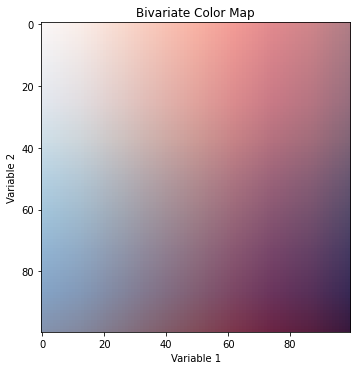

In [68]:
def colorFromBivariateData_plot(Z1,Z2,cmap1 = plt.cm.Blues, cmap2 = plt.cm.Reds):
    # Rescale values to fit into colormap range (0->255)
    Z1_plot = np.array(255*(Z1-Z1.min())/(Z1.max()-Z1.min()), dtype=np.int)
    Z2_plot = np.array(255*(Z2-Z2.min())/(Z2.max()-Z2.min()), dtype=np.int)

    Z1_color = cmap1(Z1_plot)
    Z2_color = cmap2(Z2_plot)

    # Color for each point
    Z_color = np.sum([Z1_color, Z2_color], axis=0)/2.0

    return Z_color

z1 = np.random.random((50,100))
z2 = np.random.random((50,100))
Z_color = colorFromBivariateData_plot(z1,z2)

xx, yy = np.mgrid[0:100,0:100]
C_map = colorFromBivariateData_plot(xx,yy)

fig = plt.figure(figsize=(10,5))

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(C_map)
ax2.set_title('Bivariate Color Map')
ax2.set_xlabel('Variable 1')
ax2.set_ylabel('Variable 2')

fig.tight_layout()
fig.show()

In [69]:
color_result = colorFromBivariateData(xs,ys)
color_result.shape

(121, 3)

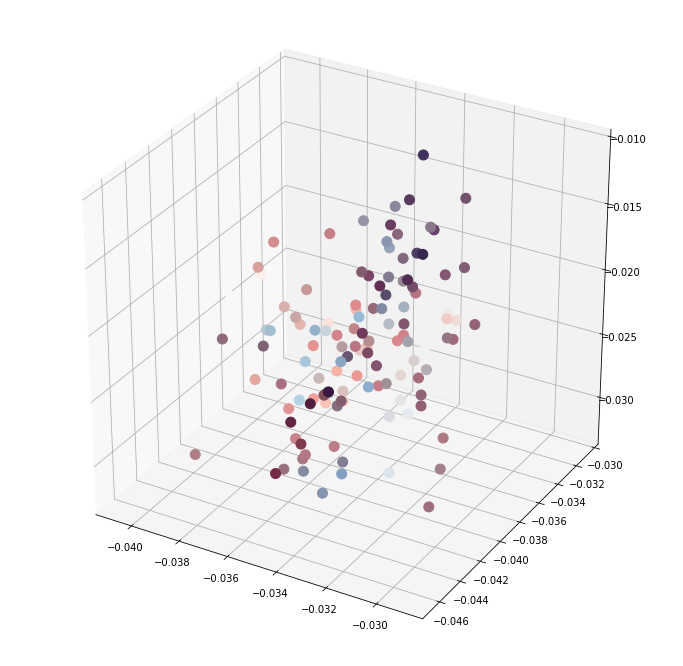

In [70]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromBivariateData(xs,ys),
        s = 100,
        alpha= 1
        ) 

plt.show()

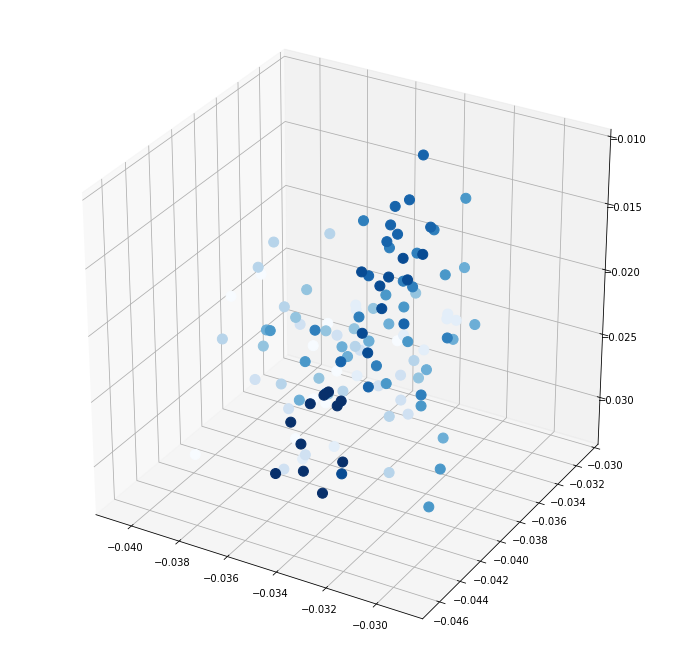

In [77]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
        s = 100,
        alpha= 1
        ) 

plt.show()

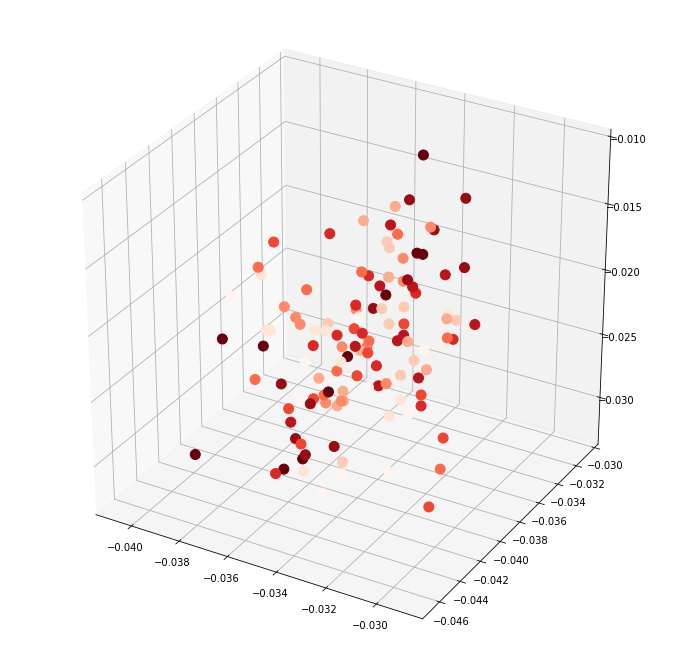

In [78]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
        s = 100,
        alpha= 1
        ) 

plt.show()

In [79]:
neuron_cluster2 = neuron_output_highest_with_shifts_projected[121:121 * 2]
neuron_label2 = neuron_labels[121:121 * 2]

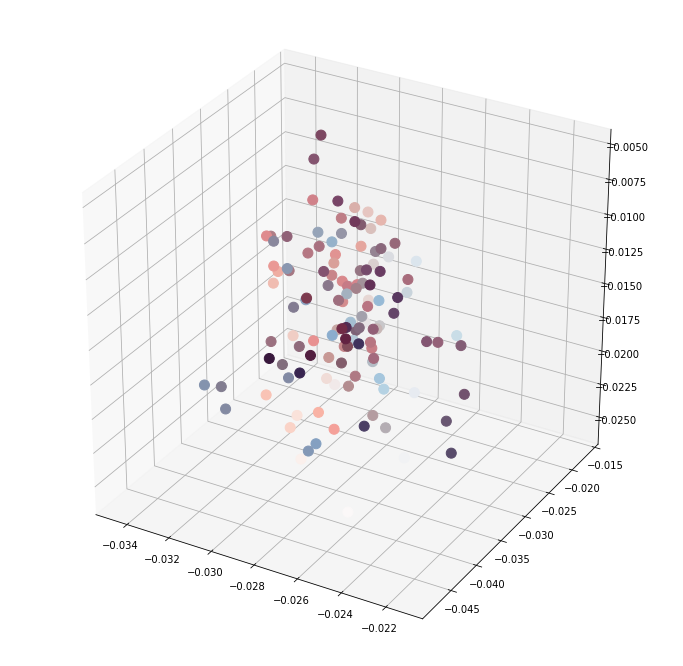

In [80]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(projection='3d')
data = neuron_cluster2
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromBivariateData(xs,ys),
        s = 100,
        alpha= 1
        )

plt.show()

(-0.2, 4.2, -0.2, 4.2)

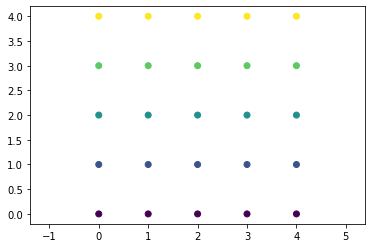

In [81]:
import numpy as np
h,v = np.meshgrid(range(5),range(5))
n_pos_i = 3
n_pos_j = 2
n_h = h[3,2]
n_v = v[3,2]
import matplotlib.pyplot as plt
X = np.stack([h.ravel()[:,None], v.ravel()[:,None]],axis=1)
plt.scatter(X[:,0],X[:,1],c=v.ravel()); plt.axis('equal')

#alternative: compute colors directly before scatter plot

# Epoch 5:

In [82]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 5')

[1,  2000] loss: 1.169
Time: 33.864665508270264
[1,  4000] loss: 1.119
Time: 67.3077962398529
[1,  6000] loss: 1.071
Time: 100.80558395385742
[1,  8000] loss: 1.030
Time: 134.27672362327576
[1, 10000] loss: 0.989
Time: 167.69782781600952
[1, 12000] loss: 0.948
Time: 201.1389925479889
[2,  2000] loss: 0.849
Time: 33.531238079071045
[2,  4000] loss: 0.845
Time: 66.96624755859375
[2,  6000] loss: 0.827
Time: 100.88830280303955
[2,  8000] loss: 0.795
Time: 134.31589913368225
[2, 10000] loss: 0.780
Time: 167.86520147323608
[2, 12000] loss: 0.775
Time: 201.50636410713196
[3,  2000] loss: 0.670
Time: 33.82597756385803
[3,  4000] loss: 0.679
Time: 67.45794463157654
[3,  6000] loss: 0.662
Time: 101.08797001838684
[3,  8000] loss: 0.657
Time: 134.74203944206238
[3, 10000] loss: 0.657
Time: 169.19334268569946
[3, 12000] loss: 0.638
Time: 204.15534806251526
[4,  2000] loss: 0.521
Time: 34.61749815940857
[4,  4000] loss: 0.548
Time: 68.57692217826843
[4,  6000] loss: 0.547
Time: 102.5083360671997
[

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)
data = np.transpose(neuron_output_highest_with_shifts, (1, 0))
mdic = {"neuron_output_2D": data}
savemat("neuron_output_2D_epoch5.mat", mdic)

In [83]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_2D_conv1_epoch5.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

(1210, 10)

In [84]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            #color=vertical_values,#(horizontal_values)
            #colorscale='Viridis',#https://plotly.com/python/line-and-scatter/#scatter-with-a-color-dimension
            opacity=1,
            #showscale= False,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


In [86]:
neuron_cluster1 = neuron_output_highest_with_shifts_projected[0:121]
neuron_label1 = neuron_labels[0:121]

In [87]:
xs, ys = np.mgrid[0:11,0:11]
xs = xs.reshape((121,))
ys = ys.reshape((121,))

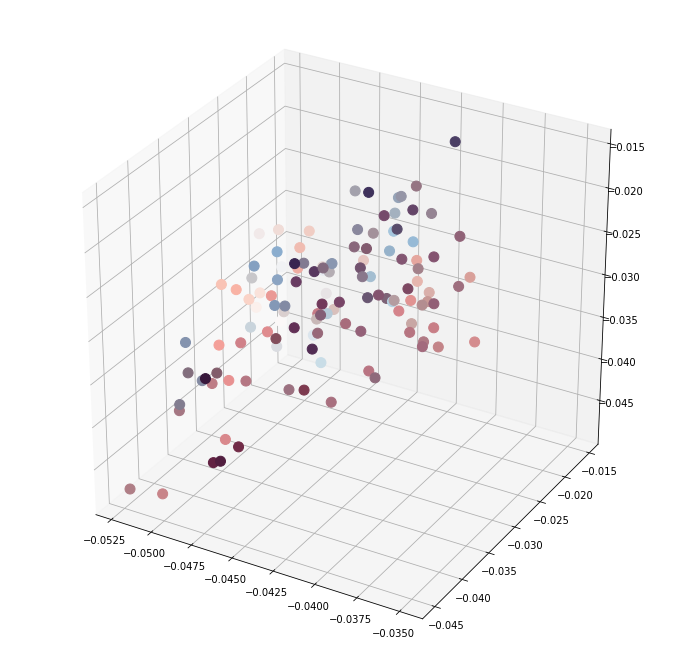

In [88]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromBivariateData(xs,ys),
        s = 100,
        alpha= 1
        ) 

plt.show()

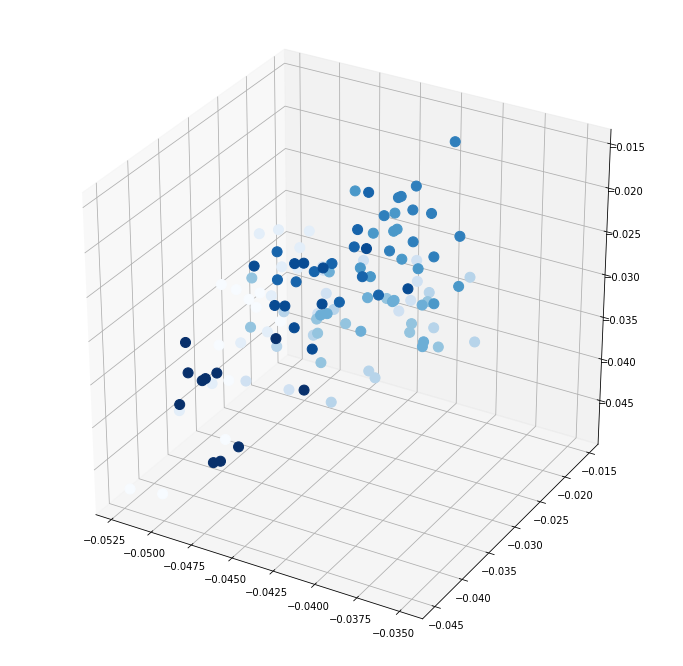

In [89]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(xs, cmap1 = plt.cm.Blues),
        s = 100,
        alpha= 1
        ) 

plt.show()

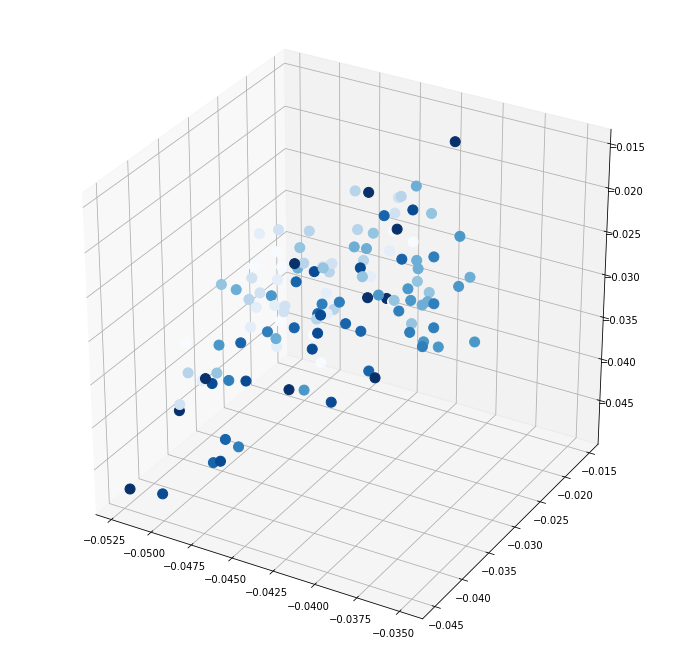

In [90]:
# %matplotlib notebook
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
data = neuron_cluster1
ax.scatter(
        data[:,0],
        data[:,1],
        data[:,2],
        c = colorFromUnivariateData(ys, cmap1 = plt.cm.Reds),
        s = 100,
        alpha= 1
        ) 

plt.show()

# Epoch 10:

In [85]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 10')

[1,  2000] loss: 0.419
Time: 34.900317907333374
[1,  4000] loss: 0.445
Time: 69.33469820022583
[1,  6000] loss: 0.461
Time: 103.75255703926086
[1,  8000] loss: 0.462
Time: 137.8670163154602
[1, 10000] loss: 0.460
Time: 172.00978231430054
[1, 12000] loss: 0.475
Time: 206.10266017913818
[2,  2000] loss: 0.328
Time: 34.719000577926636
[2,  4000] loss: 0.368
Time: 68.99282574653625
[2,  6000] loss: 0.380
Time: 103.73466324806213
[2,  8000] loss: 0.398
Time: 138.35866594314575
[2, 10000] loss: 0.405
Time: 172.8378381729126
[2, 12000] loss: 0.403
Time: 206.96196246147156
[3,  2000] loss: 0.263
Time: 34.427268981933594
[3,  4000] loss: 0.309
Time: 68.76992535591125
[3,  6000] loss: 0.315
Time: 102.90374517440796
[3,  8000] loss: 0.330
Time: 137.21479630470276
[3, 10000] loss: 0.351
Time: 171.56615543365479
[3, 12000] loss: 0.342
Time: 205.84267830848694
[4,  2000] loss: 0.219
Time: 34.33475303649902
[4,  4000] loss: 0.247
Time: 68.31935906410217
[4,  6000] loss: 0.269
Time: 102.38046073913574

In [92]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)
data = np.transpose(neuron_output_highest_with_shifts, (1, 0))
mdic = {"neuron_output_2D": data}

NameError: ignored

In [93]:
from scipy.io import savemat
savemat("neuron_output_2D_epoch10.mat", mdic)

In [94]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_2D_conv1_epoch10.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

(1210, 10)

In [95]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 121
1 121
2 121
3 121
4 121
5 121
6 121
7 121
8 121
9 121


# Epoch 15:

In [ ]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 15')

[1,  2000] loss: 0.041
Time: 43.72062802314758
[1,  4000] loss: 0.046
Time: 83.14854788780212
[1,  6000] loss: 0.049
Time: 122.87277340888977
[1,  8000] loss: 0.039
Time: 162.31593561172485
[1, 10000] loss: 0.072
Time: 202.4207422733307
[1, 12000] loss: 0.059
Time: 242.61818766593933
[2,  2000] loss: 0.021
Time: 40.6830370426178
[2,  4000] loss: 0.039
Time: 80.18149209022522
[2,  6000] loss: 0.032
Time: 119.70345759391785
[2,  8000] loss: 0.041
Time: 159.20094919204712
[2, 10000] loss: 0.041
Time: 198.87737798690796
[2, 12000] loss: 0.065
Time: 238.43901777267456
[3,  2000] loss: 0.034
Time: 42.04613375663757
[3,  4000] loss: 0.026
Time: 82.408038854599
[3,  6000] loss: 0.024
Time: 122.58976793289185
[3,  8000] loss: 0.051
Time: 162.13545513153076
[3, 10000] loss: 0.045
Time: 202.40321326255798
[3, 12000] loss: 0.034
Time: 241.6814467906952
Finished Training of AlexNet: Epoch 15


In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
mdic = {"neuron_output_3D": data}
savemat("neuron_output_3D_epoch15.mat", mdic)

In [ ]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_3D_conv1_epoch15.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

(5290, 10)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 529
1 529
2 529
3 529
4 529
5 529
6 529
7 529
8 529
9 529


# Epoch 20:

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 20')

[1,  2000] loss: 0.030
Time: 39.865222454071045
[1,  4000] loss: 0.021
Time: 79.90001678466797
[1,  6000] loss: 0.031
Time: 120.00790762901306
[1,  8000] loss: 0.019
Time: 159.22374153137207
[1, 10000] loss: 0.043
Time: 200.90038800239563
[1, 12000] loss: 0.043
Time: 243.47038102149963
[2,  2000] loss: 0.027
Time: 39.484355449676514
[2,  4000] loss: 0.019
Time: 80.00254273414612
[2,  6000] loss: 0.025
Time: 119.88675045967102
[2,  8000] loss: 0.040
Time: 159.25482892990112
[2, 10000] loss: 0.036
Time: 199.16366052627563
[2, 12000] loss: 0.042
Time: 238.2889211177826
[3,  2000] loss: 0.024
Time: 39.77900719642639
[3,  4000] loss: 0.028
Time: 78.9079577922821
[3,  6000] loss: 0.021
Time: 117.73241019248962
[3,  8000] loss: 0.018
Time: 156.58984684944153
[3, 10000] loss: 0.021
Time: 195.49601697921753
[3, 12000] loss: 0.036
Time: 234.65127110481262
[4,  2000] loss: 0.034
Time: 39.48714089393616
[4,  4000] loss: 0.032
Time: 79.03998351097107
[4,  6000] loss: 0.019
Time: 118.52274894714355


In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
mdic = {"neuron_output_3D": data}
savemat("neuron_output_3D_epoch20.mat", mdic)

In [ ]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_3D_conv1_epoch20.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

(5290, 10)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 529
1 529
2 529
3 529
4 529
5 529
6 529
7 529
8 529
9 529


# Epoch 25:

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    start_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = AlexNet_Model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        #Time
        end_time = time.time()
        time_taken = end_time - start_time

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            print('Time:',time_taken)
            running_loss = 0.0

print('Finished Training of AlexNet: Epoch 25')

[1,  2000] loss: 0.017
Time: 49.760414361953735
[1,  4000] loss: 0.018
Time: 89.63668513298035
[1,  6000] loss: 0.016
Time: 129.02608585357666
[1,  8000] loss: 0.021
Time: 168.94069910049438
[1, 10000] loss: 0.020
Time: 208.40851950645447
[1, 12000] loss: 0.018
Time: 248.2285304069519
[2,  2000] loss: 0.012
Time: 39.72936773300171
[2,  4000] loss: 0.013
Time: 79.01610517501831
[2,  6000] loss: 0.022
Time: 118.48379635810852
[2,  8000] loss: 0.029
Time: 157.94817399978638
[2, 10000] loss: 0.047
Time: 198.00206303596497
[2, 12000] loss: 0.014
Time: 238.13546299934387
[3,  2000] loss: 0.011
Time: 39.38021397590637
[3,  4000] loss: 0.012
Time: 78.92299437522888
[3,  6000] loss: 0.010
Time: 118.20717406272888
[3,  8000] loss: 0.014
Time: 157.34929180145264
[3, 10000] loss: 0.022
Time: 196.67537307739258
[3, 12000] loss: 0.030
Time: 235.95967388153076
[4,  2000] loss: 0.007
Time: 39.81028413772583
[4,  4000] loss: 0.010
Time: 78.97323298454285
[4,  6000] loss: 0.014
Time: 118.4112458229065
[

In [ ]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels = show_stimuli(['conv_layer1'], images_selected_classes, shifts = True)
data = np.transpose(neuron_output_highest_with_shifts, (2, 0, 1))
mdic = {"neuron_output_3D": data}
savemat("neuron_output_3D_epoch25.mat", mdic)

In [ ]:
from scipy.io import loadmat 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
F = loadmat('factors_opt_nonneg_3D_conv1_epoch25.mat')['F']
pca = PCA(10)
neuron_output_highest_with_shifts_projected =  pca.fit_transform(F)
neuron_output_highest_with_shifts_projected.shape

(5290, 10)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[int(label)],
            opacity=1,
            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 529
1 529
2 529
3 529
4 529
5 529
6 529
7 529
8 529
9 529


# Appendix:

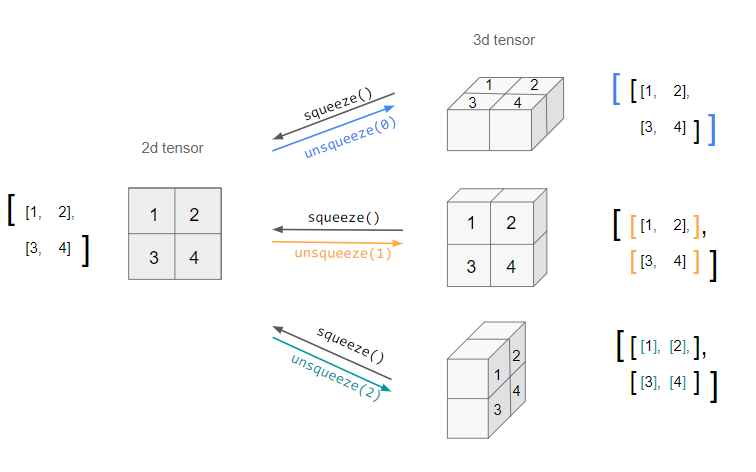

resizing imagenet: 

https://discuss.pytorch.org/t/how-do-i-resize-imagenet-image-to-224-x-224/66979

https://pytorch.org/vision/stable/_modules/torchvision/datasets/imagenet.html#ImageNet